In [142]:
from random import randrange
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', context='notebook')
sns.set_color_codes('dark')

k = 1

sd = int(dt.datetime(2016, 8, 4).timestamp())
team_num = 10
times = []
for i in range(team_num):
    times.append([randrange(2), dt.datetime.fromtimestamp(sd + 60 * int(randrange(14400 + 7200) / 60))])
    
df = pd.DataFrame(times, columns = ['tt', 'time'])
names = ['Alice', 'Bob', 'Clark', 'David', 'Ed', 'Frank', 'George', 'Helen', 'Ivan', 'John', 'Kelly', 'Lance', 'Mario',
        'Nolan', 'Oleg', 'Paul', 'Quentin', 'Ricky', 'Steve', 'Thomas', 'Ulaf', 'Valera', 'Wayne', 'Xi', 'Yang', 'Zed']
df['ts'] = df.time.apply(lambda x: int(x.timestamp()))
df['ts_norm'] = (df.ts - df.ts.mean()) / k
df = df.sort_values('ts').reset_index()
df['name'] = names[:team_num]
df.drop('index', axis=1, inplace=True)
df

,tt,time,ts,ts_norm,name
0,1,2016-08-04 01:45:00,1470264300,-7854,Alice
1,0,2016-08-04 02:17:00,1470266220,-5934,Bob
2,0,2016-08-04 02:42:00,1470267720,-4434,Clark
3,1,2016-08-04 03:09:00,1470269340,-2814,David
4,1,2016-08-04 03:10:00,1470269400,-2754,Ed
5,0,2016-08-04 04:24:00,1470273840,1686,Frank
6,0,2016-08-04 04:57:00,1470275820,3666,George
7,1,2016-08-04 05:15:00,1470276900,4746,Helen
8,1,2016-08-04 05:43:00,1470278580,6426,Ivan
9,1,2016-08-04 05:57:00,1470279420,7266,John


In [143]:
slot_num = 4
times = []
for i in range(slot_num):        
    times.append([randrange(2), dt.datetime.fromtimestamp(sd + 7200 + 60 * int(randrange(7200) / 60))])
    
df_slot = pd.DataFrame(times, columns = ['tt', 'time'])
df_slot = df_slot.sort_values('time')
train_names = ['train' + str(x) for x in np.arange(slot_num)]
df_slot['name'] = train_names
df_slot['ts'] = df_slot.time.apply(lambda x: int(x.timestamp()))
df_slot['ts_norm'] = (df_slot.ts - df_slot.ts.mean()) / k
norm_sh = df.ts_norm.min() - df_slot.ts_norm.min()
df_slot['ts_norm_shift'] = df_slot.ts_norm + norm_sh
df_slot = df_slot.reset_index().drop('index', axis=1)
df_slot

,tt,time,name,ts,ts_norm,ts_norm_shift
0,1,2016-08-04 02:07:00,train0,1470265620,-3240,-7854
1,0,2016-08-04 02:57:00,train1,1470268620,-240,-4854
2,1,2016-08-04 03:11:00,train2,1470269460,600,-4014
3,1,2016-08-04 03:49:00,train3,1470271740,2880,-1734


In [148]:
def new_util(x):
    u = []
    t_t = x.ts_norm
    for t_i in train_times:
        add = 0 if x.tt == 1 else 1 - (t_i - t_t) / 15000        
        delta = (t_i - t_t) / 3600       
        util = np.exp(-(delta ** 2)) + 0.2 * add
        u.append(util)
    return pd.Series(u)

def prev_util(x):
    #t_t = x.ts
    t_t = x.ts_norm
    u = []
    #t_0 = df_slot[df_slot.ts >= t_t].ts.min()
    t_0 = df_slot[df_slot.ts_norm >= t_t].ts.min()
    for t_i in train_times:
        if t_t > t_i:
            util = 0
        else:
            add = 0 if x.tt == 1 else 1 - (t_i - t_t) / 150
            #util = np.round(((t_0 - t_t) / np.exp((t_i - t_0))) / 1000 + 1.0 * add, 3)            
            #util = (t_0 - t_t) / 
        u.append(util)
    return pd.Series(u) 

def get_util(x):
    t_t = x.ts
    u = []
    for t_i in train_times:        
        #print(t_i - t_t, add)
        if (team_num < slot_num) & (t_t > t_i):
            add = 1 - np.exp(-0.5*((t_i - t_t))**2)
            util = 1.0 + 0.1 * add
        else:
            add = 0 if x.tt == 1 else 1 - (t_i - t_t) / 150
            if (x.tt == 1) & (t_t > t_i):
                k = 20
            else:
                k = 5        
            delta_h = (t_t - t_i)
            util = np.exp(-(delta_h ** 2) / k) + 0.1 * add
        u.append(util)
    return pd.Series(u)    
    

df.drop([x for x in df.columns if 'train' in x], axis=1, inplace=True)
train_list = sorted(df_slot.name.unique())
#train_times = list(df_slot.ts.values)
train_times = list(df_slot.ts_norm_shift.values)
df[train_list] = df.apply(lambda x: new_util(x), axis=1)

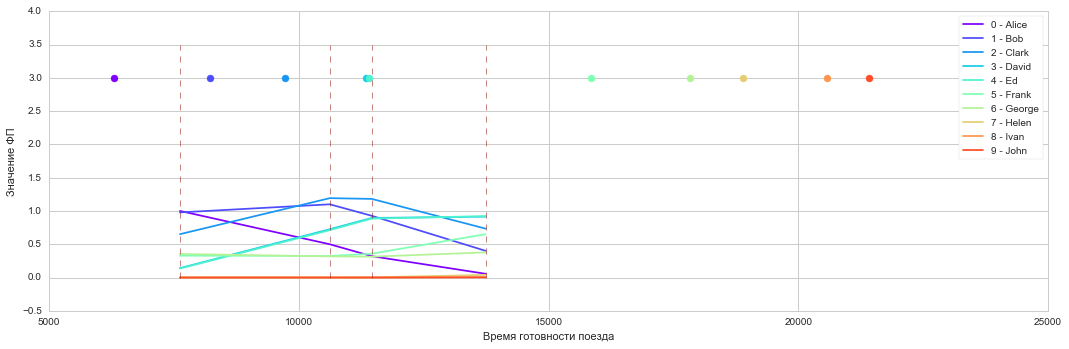

In [145]:
plt.figure(figsize=(15, 5))
cmap = matplotlib.cm.rainbow
for i in range(len(df.index)):
    plt.plot(df_slot.ts - sd, df.ix[i][train_list], label='%d - %s' % (i, df.ix[i]['name']), color=cmap(i / float(team_num)))
    plt.scatter(df.ix[i].ts - sd, 3.0, color=cmap(i / float(team_num)), s=50)

plt.xlabel('Время готовности поезда')
plt.ylabel('Значение ФП')
for t in df_slot.ts.values:
    plt.plot([t - sd] * 100, np.linspace(0, 3.5, 100), 'r--', lw=0.5)
    
#plt.xticks(df_slot.ts, df_slot.time, rotation=45)
plt.legend(loc='best', frameon=True)
plt.tight_layout()

In [146]:
from scipy import optimize
row, col = optimize.linear_sum_assignment(-df[train_list].as_matrix())
print(sorted(list(zip(['train %d' % t for t in col], df.ix[row].name))))
df['bt'] = -1
df.ix[row, 'bt'] = col

def get_max(row):
    l = row[train_list]
    is_max = row.index == ('train' + str(int(row.bt)))    
    return ['background-color: yellow' if v else '' for v in is_max]    

print(df_slot[['name', 'time', 'ts_norm']])
df.sort_values('ts').style.apply(get_max, axis=1)

[('train 0', 'Alice'), ('train 1', 'Bob'), ('train 2', 'Clark'), ('train 3', 'Ed')]
     name                time  ts_norm
0  train0 2016-08-04 02:07:00    -3240
1  train1 2016-08-04 02:57:00     -240
2  train2 2016-08-04 03:11:00      600
3  train3 2016-08-04 03:49:00     2880


In [125]:
a = pd.melt(df.sort_values('ts').reset_index()[train_list])
a.columns = ['train', 'util']
a['train'] = a.train.apply(lambda x: int(x[-1]))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure().gca(projection='3d')
#ax = fig.add_subplot(111, projection='3d')

fig.scatter(a.index, a.train, a.util, c='r', marker='o')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

plt.show()

In [ ]:
x = np.linspace(0, 4, 100)
plt.figure(figsize=(12, 5))
t_0 = 2
x1 = np.array([i for i in x if i >= t_0])
x2 = np.array([i for i in x if i < t_0])
for k in [5, 20]:
    y1 = np.exp(-((x1 - t_0)**2) / k)
    y2 = np.exp(-((x2 - t_0)**2) / 50)
    plt.scatter(x1, y1, color=cmap(k / float(100)), s=5, label='k=%d' % k)
    plt.scatter(x2, y2, color=cmap(k / float(100)), s=5, label='k=%d' % k)
#k = [ for i in x ]
plt.ylim(-0.2, 1.2)
plt.legend()

In [5]:
%run read.py
%run common.py

Load data from file "input/jason-FullPlannerPlugin.log"
[('current_time', 2), ('fact_loco', 2106), ('fact_loco_next_service', 2106), ('fact_team_location', 4944), ('fact_team_ready', 4944), ('link', 746), ('loco_attributes', 2106), ('loco_info_regs', 0), ('loco_nums', 0), ('loco_tonnage', 11688), ('prev_team', 4200), ('routes', 0), ('service', 0), ('service_station', 9328), ('slot', 7443), ('slot_loco', 1657), ('slot_pass', 2516), ('slot_team', 4664), ('slot_train', 4797), ('station', 501), ('station_names', 0), ('support', 9363), ('task', 714), ('team_attributes', 4944), ('team_nums', 0), ('team_region', 0), ('team_work_region', 2037), ('train_arrive', 568), ('train_depart', 1204), ('train_index', 0), ('train_info', 1958), ('train_oper', 0), ('train_ready', 302)]
Файл resources/fact_loco.csv успешно создан
Файл resources/train_arrive.csv успешно создан
Файл resources/train_info.csv успешно создан
Файл resources/station_names.csv успешно создан
Файл resources/task.csv успешно создан
Фа

In [15]:
# pt = pd.read_csv(FOLDER + 'prev_team.csv')
# pt.to_csv('prev.csv', index=False)
pt = pd.read_csv('prev.csv', dtype={'team':str})
pt['plan_ready_time'] = pt.team.map(team_plan[team_plan.state == 2].drop_duplicates('team').set_index('team').time_start)
pt[pt.prev_ready_time != pt.plan_ready_time]

,team,prev_ready_time,plan_ready_time
110,200200146132,1470770940,1470686400
307,200200168028,1470716358,1470686958
525,777700077325,1470764514,1470723205
1157,200200155242,1470807594,1470772674
3065,777700077315,1470770956,1470747000
3328,200200251565,1470834900,1470788688


In [13]:
a = pt[pt.prev_ready_time != pt.plan_ready_time].team
cols = ['team', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'state', 'loco']
for team in a:
    print(team_plan[team_plan.team == team][cols].to_string(index=False))
    print('\n')

         team st_from_name   st_to_name  time_start    time_end  state          loco
 200200146132  НОВЫЙ УРГАЛ  НОВЫЙ УРГАЛ  1470686400  1470693600      2            -1
 200200146132        ТЫРМА     ТАЛАНДЖА  1470709620  1470717928      1  200200062580
 200200146132     ТАЛАНДЖА  ПЕРЕВАЛЬНЫЙ  1470717928  1470721078      1  200200062580
 200200146132  ПЕРЕВАЛЬНЫЙ      КУЛЬДУР  1470721078  1470722758      1  200200062580
 200200146132      КУЛЬДУР  ИЗВЕСТКОВАЯ  1470722758  1470726178      1  200200062580
 200200146132  ИЗВЕСТКОВАЯ      ОБЛУЧЬЕ  1470726178  1470729478      1  200200062580
 200200146132      ОБЛУЧЬЕ      ОБЛУЧЬЕ  1470731278  1470756480      4            -1
 200200146132      ОБЛУЧЬЕ  ИЗВЕСТКОВАЯ  1470756480  1470759720      0            -1
 200200146132  ИЗВЕСТКОВАЯ  ИЗВЕСТКОВАЯ  1470770940  1470776700      2            -1
 200200146132  ИЗВЕСТКОВАЯ      КУЛЬДУР  1470776700  1470781200      1  200200068089
 200200146132      КУЛЬДУР  ПЕРЕВАЛЬНЫЙ  1470781200  1470783840  

In [23]:
st1, st2 = 'ИРКУТСК-СОРТИРОВОЧНЫЙ', 'ГОНЧАРОВО'
print(nice_time(current_time))
train_plan['dt_start'] = train_plan.time_start.apply(datetime.datetime.fromtimestamp)
train_plan['train_type'] = train_plan.train.apply(lambda x: int(x[0]))
train_plan[(train_plan.st_from_name == st1) 
           & (train_plan.st_to_name == st2)
          & (train_plan.time_start < current_time * 24*3600)
          & (train_plan.train_type != 8)].set_index('dt_start').train.resample('1H', 'count')

Aug 09, 07:30


dt_start
2016-08-09 06:00:00    3
2016-08-09 07:00:00    1
2016-08-09 08:00:00    5
2016-08-09 09:00:00    2
2016-08-09 10:00:00    7
2016-08-09 11:00:00    8
2016-08-09 12:00:00    3
2016-08-09 13:00:00    0
2016-08-09 14:00:00    0
2016-08-09 15:00:00    0
2016-08-09 16:00:00    0
2016-08-09 17:00:00    1
2016-08-09 18:00:00    3
2016-08-09 19:00:00    2
2016-08-09 20:00:00    0
2016-08-09 21:00:00    3
2016-08-09 22:00:00    5
2016-08-09 23:00:00    1
2016-08-10 00:00:00    4
2016-08-10 01:00:00    3
2016-08-10 02:00:00    3
2016-08-10 03:00:00    5
2016-08-10 04:00:00    0
2016-08-10 05:00:00    2
2016-08-10 06:00:00    0
                      ..
2016-08-26 15:00:00    0
2016-08-26 16:00:00    0
2016-08-26 17:00:00    0
2016-08-26 18:00:00    0
2016-08-26 19:00:00    0
2016-08-26 20:00:00    0
2016-08-26 21:00:00    0
2016-08-26 22:00:00    0
2016-08-26 23:00:00    0
2016-08-27 00:00:00    0
2016-08-27 01:00:00    0
2016-08-27 02:00:00    0
2016-08-27 03:00:00    0
2016-08-27 04:00

## Метод аукционов

In [434]:
r, c = 4, 4
util = [float(i) for i in np.random.randint(10, size=r*c)]
util = np.array(util).reshape(r, c)
util0 = util.copy()
util

array([[ 7.,  3.,  3.,  4.],
       [ 3.,  7.,  4.,  2.],
       [ 7.,  2.,  1.,  7.],
       [ 9.,  8.,  9.,  4.]])

In [435]:
k0 = [i for i in range(util.shape[1]) if i%2==0]
k1 = [i for i in range(util.shape[1]) if i%2==1]
k0, k1
best_rate = 1.0 # k0 / k_all

In [436]:
def get_error(curr_rates, best_rates):
    return round(np.sqrt(sum((np.array(curr_rates) - np.array(best_rates)) ** 2)) / len(best_rates), 4)

In [437]:
from scipy import optimize
row, col = optimize.linear_sum_assignment(-util)
print(sum(util[row, col]))
print(row, col)
best_sum = sum(util0[row, col])
eps, eps_err = 0.01, 0.00001

curr_k0 = len([i for i in col if i in k0])
curr_k1 = len([i for i in col if i in k1])
total = len(col)
std = get_error([curr_k0 / total, curr_k1 / total], [best_rate, 1 - best_rate])
print(std)
curr_rate = curr_k0 / (curr_k0 + curr_k1)
curr_rate_err = curr_rate - best_rate
print(curr_k0, curr_k1, curr_rate, best_rate, std)

l = 0 if curr_rate_err > 0 else 1
err_ind = [i for i in range(len(col)) if col[i]%2 == l]

res, err_rate = [best_sum], [1000, std]
assign = [(row, col)]
print(res, err_rate)
while (err_rate[-2] >= err_rate[-1]) & (err_rate[-1] != 0):
    delta = []
    for i in err_ind:
        r, c = row[i], col[i]
        m = max([j for j in util[r, k0] if util[r, c] > j])
        delta.append(util[r, c] - m)
        #print(r, c, delta)

    d = min(delta) + eps
    util[row[l], col[l]] -= d
    row, col = optimize.linear_sum_assignment(-util)
    print(row, col)    
    l = 0 if curr_rate_err > 0 else 1
    err_ind = [i for i in range(len(col)) if col[i]%2 == l]
    res.append(sum(util0[row, col]))
    curr_k0 = len([i for i in col if i in k0])
    curr_k1 = len([i for i in col if i in k1])
    curr_rate = curr_k0 / (curr_k0 + curr_k1)
    curr_rate_err = curr_rate - best_rate
    #err_rate.append(np.abs(curr_rate_err))
    #print(res, curr_k0, curr_k1, curr_rate, best_rate, curr_rate_err)
    std = get_error([curr_k0 / total, curr_k1 / total], [best_rate, 1 - best_rate])
    err_rate.append(std)
    print(res, curr_k0, curr_k1, curr_rate, best_rate, std)
    assign.append((row, col))
    #print(res, current_rate_err)    
    
print('End')
# print(row, col)
# print(sum(util[row, col]))
# print(res, err_rate[1:])

30.0
[0 1 2 3] [0 1 3 2]
0.3536
2 2 0.5 1.0 0.3536
[30.0] [1000, 0.35360000000000003]
[0 1 2 3] [0 1 3 2]
[30.0, 30.0] 2 2 0.5 1.0 0.3536
[0 1 2 3] [0 2 3 1]
[30.0, 30.0, 26.0] 2 2 0.5 1.0 0.3536


ValueError: max() arg is an empty sequence

In [433]:
res_norm = 1 - res / best_sum
err = np.sqrt(res_norm ** 2 + np.array(err_rate[1:]) ** 2) / 2
print(res_norm)
print(err_rate[1:])
print(err)
assign_ind = np.argmin(err)
print(assign[assign_ind])
print(sum(util0[assign[assign_ind]]))

[ 0.          0.          0.01587302]
[0.20200000000000001, 0.20200000000000001, 0.30299999999999999]
[ 0.101       0.101       0.15170774]
(array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 2, 18, 11,  4,  0, 13,  8], dtype=int64))
63.0


In [438]:
%run common.py

Planning start time: Jul 13, 10:00 (1468393200)


In [565]:
lines = []
with open('out.txt') as f:
    for line in f:
        lines.append(line[:-1])
        
a = [int(line.split('?')[-1].strip()) for line in lines[:18]]
pd.Series(a).apply(datetime.datetime.fromtimestamp).sort_values()
df_loco = pd.DataFrame([[line.split('?')[1].strip(), int(line.split('?')[-1].strip())] for line in lines[:18]], 
                       columns=['loco', 'time'])

In [562]:
b = [[line.split('?')[1].strip(), int(line.split('?')[-2].strip()), line.split('?')[-1].strip()] for line in lines[19:]]
#teams = [line.split('?')[1].strip() for line in lines[19:]]
#pd.Series(b).apply(datetime.datetime.fromtimestamp).sort_values()
df_team = pd.DataFrame(b, columns=['team', 'time', 'loco'])
df_team['dt'] = df_team.time.apply(datetime.datetime.fromtimestamp)
df_team = df_team.set_index('team')
df_team

,time,loco,dt
team,,,
200200235107,1470727848,200200105418,2016-08-09 10:30:48
210203241345,1470728280,0,2016-08-09 10:38:00
200200250431,1470735840,200200104920,2016-08-09 12:44:00
200200258013,1470739260,200200090702,2016-08-09 13:41:00
200200240604,1470743778,0,2016-08-09 14:56:18
200200254896,1470747853,0,2016-08-09 16:04:13
200200260598,1470748843,0,2016-08-09 16:20:43
200200197542,1470750643,0,2016-08-09 16:50:43
200200105777,1470756168,200200052421,2016-08-09 18:22:48


shift 0 = -1206
shift 1 = -1379
shift 2 = 3511
shift 3 = 4899
shift 4 = 6618
shift 5 = 8293
shift 6 = 6223
shift 7 = 8018
shift 8 = 12926
shift 9 = 13615
shift 10 = 13154
shift 11 = 15405
shift 12 = 16160
shift 13 = 15521
shift 14 = 15060
shift 15 = 15285
shift 16 = 14870
shift 17 = 15286


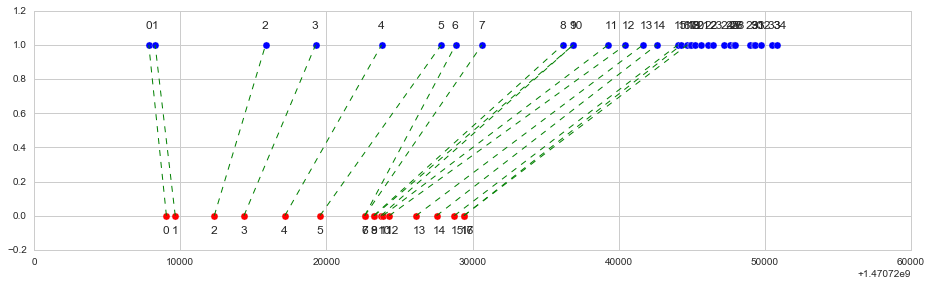

In [527]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(14, 4))
plt.scatter(a, [0.0] * len(a), c='r', s=50, label='loco')
plt.scatter(b, [1.0] * len(b), c='b', s=50, label='team')
for i in range(len(a)):
    plt.plot([a[i], b[i]], [0.0, 1.0], 'g--', lw=1.0)    
    print('shift %d = %d' % (i, b[i]-a[i]))
    plt.annotate(xy=(a[i]-250, -0.1), s=i)
    
for j in range(len(b)):
    plt.annotate(xy=(b[j]-250, 1.1), s=j)   


In [528]:
print(datetime.datetime.fromtimestamp(1470739560))
print(datetime.datetime.fromtimestamp(1470756168))
print(datetime.datetime.fromtimestamp(1470786408))
print(datetime.datetime.fromtimestamp(1470773400))
print(nice_time(current_time))

2016-08-09 13:46:00
2016-08-09 18:22:48
2016-08-10 02:46:48
2016-08-09 23:10:00
Aug 09, 10:30


In [579]:
df_team['line'] = ''
e = {}
with open('out2.txt', encoding='utf-8-sig') as f:
    for line in f:
        q = line[:-1].split(' - ')[1]
        #team = q.split()[0][5:]
        #loco = q.split()[1][5:]
        l = [t for t in teams if t in q]
        if l !=[]:
            #print(l, line[line.find(' - ')+3:-1])
            e[l[0]] = line[line.find(' - ')+3:-1]

df_team = df_team.reset_index()
df_team['line'] = df_team.team.apply(lambda x: e[x])
df_team

,team,time,loco,dt,loco_time,line
0,200200235107,1470727848,200200105418,2016-08-09 10:30:48,1470732329,team:200200235107 loco:200200091438 !team.correspondenceInTeamRegion(loco)
1,210203241345,1470728280,0,2016-08-09 10:38:00,NaN,team:210203241345 loco:200200091438 !team.correspondenceInTeamRegion(loco)
2,200200250431,1470735840,200200104920,2016-08-09 12:44:00,1470729054,team:200200250431 loco:200200091438 !team.correspondenceInTeamRegion(loco)
3,200200258013,1470739260,200200090702,2016-08-09 13:41:00,1470729659,"Полезность для локомотива 200200091438, бригады 200200258013: {k1:-1.5 accountWaitTime:0.14644731510621908 k4:-0.3204} = -1,454282"
4,200200240604,1470743778,0,2016-08-09 14:56:18,NaN,team:200200240604 loco:200200091438 !team.correspondenceInTeamRegion(loco)
5,200200254896,1470747853,0,2016-08-09 16:04:13,NaN,team:200200254896 loco:200200091438 !team.correspondenceInTeamRegion(loco)
6,200200260598,1470748843,0,2016-08-09 16:20:43,NaN,team:200200260598 loco:200200091438 whenTeamWillBeRelocated - locoStartTime > params.maxTimeLocoWaitsForTeam
7,200200197542,1470750643,0,2016-08-09 16:50:43,NaN,team:200200197542 loco:200200091438 !team.correspondenceInTeamRegion(loco)
8,200200105777,1470756168,200200052421,2016-08-09 18:22:48,1470746141,"team:200200105777 loco:200200091438 Время старта позже, чем время пред. явки бригады time:1470786408 prevTeamTime + 2 + d:1470773400"
9,200200182874,1470756895,0,2016-08-09 18:34:55,NaN,team:200200182874 loco:200200091438 !team.correspondenceInTeamRegion(loco)


shift 0 = -1206
shift 1 = -1379
shift 2 = 3511
shift 3 = 4899
shift 4 = 6618
shift 5 = 8293
shift 6 = 6223
shift 7 = 8018
shift 8 = 12926
shift 9 = 13615
shift 10 = 13154
shift 11 = 15405
shift 12 = 16160
shift 13 = 15521
shift 14 = 15060
shift 15 = 15285
shift 16 = 14870
shift 17 = 15286


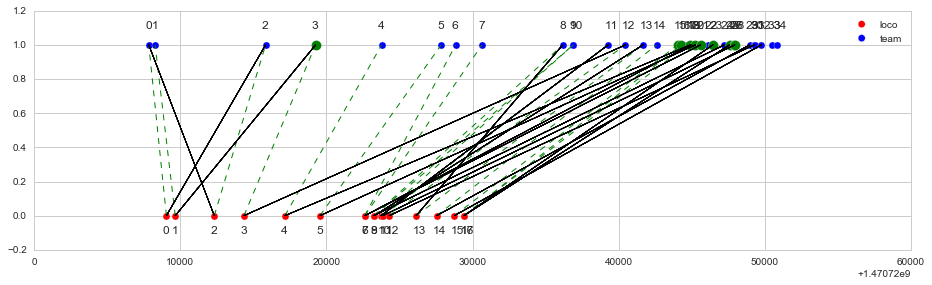

In [581]:
sns.set(style='whitegrid', context='notebook')
b = df_team.time
plt.figure(figsize=(14, 4))
plt.scatter(a, [0.0] * len(a), c='r', s=50, label='loco')
plt.scatter(b, [1.0] * len(b), c='b', s=50, label='team')
good = df_team[df_team.line.apply(lambda x: 'Полезность' in x)].time
plt.scatter(good, [1.0] * len(good), s=100, c='g')
for i in range(len(a)):
    plt.plot([a[i], b[i]], [0.0, 1.0], 'g--', lw=1.0)    
    print('shift %d = %d' % (i, b[i]-a[i]))
    plt.annotate(xy=(a[i]-250, -0.1), s=i)
    
for j in range(len(b)):
    plt.annotate(xy=(b[j]-250, 1.1), s=j)
    
df_team['loco_time'] = df_team.loco.map(df_loco.set_index('loco').time)
lt = df_team[df_team.loco != '0'].dropna().loco_time
tt = df_team[df_team.loco != '0'].dropna().time
for i in range(len(tt)):
    plt.plot([lt, tt], [0.0, 1.0], c='black', lw=0.7)
plt.legend(loc='best')

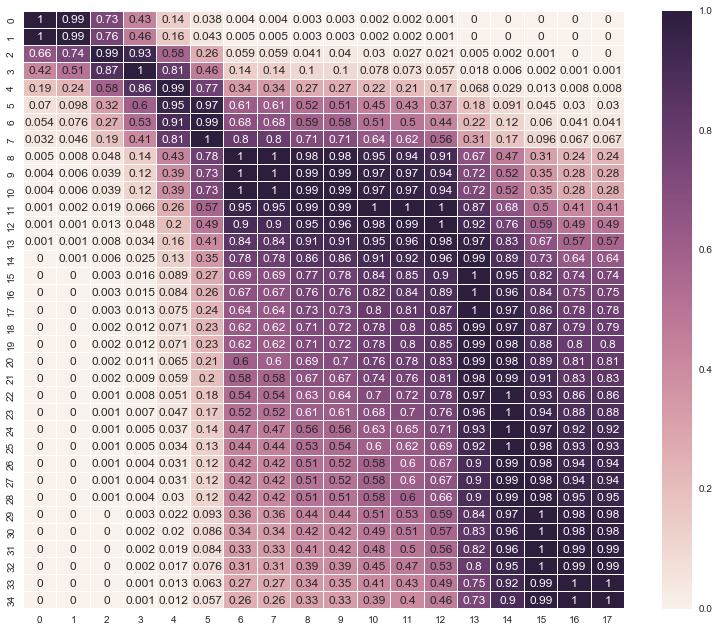

In [631]:
def get_util(x):
    u = []
    for t_i in train_times:        
        delta = COEF * (t_i - x.ts_norm)
        util = np.exp(-(delta ** 2))
        u.append(util)
    return pd.Series(u)   

df_loco['ts_norm'] = (df_loco.time - df_loco.time.min()) / (df_loco.time.max() - df_loco.time.min())
df_team['ts_norm'] = (df_team.time - df_team.time.min()) / (df_team.time.max() - df_team.time.min())
COEF = max(len(df_loco.ts_norm), len(df_team.ts_norm)) / 10
#sh = df_team.ts_norm.min() - df_loco.ts_norm.min()
#df_loco['ts_norm'] = df_loco.ts_norm + sh
train_times = df_loco.ts_norm
a = df_team.apply(lambda row: get_util(row), axis=1).applymap(lambda x: round(x, 3))
#a.style.applymap(lambda x: 'background-color: yellow' if x > 0.5 else '')
plt.figure(figsize=(12, 10))
sns.heatmap(a, annot=True, lw=0.01)

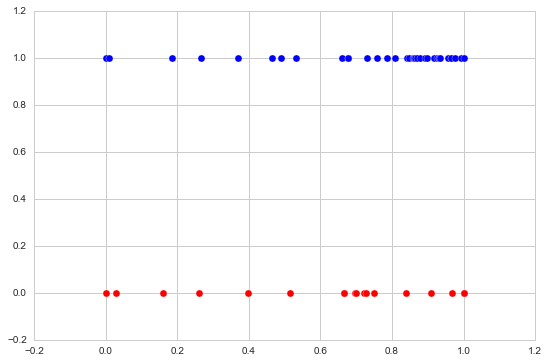

In [625]:
plt.scatter(df_loco.ts_norm, [0.0] * len(df_loco.ts_norm), s=50, c='r')
plt.scatter(df_team.ts_norm, [1.0] * len(df_team.ts_norm), s=50, c='b')

In [50]:
%run common.py

Planning start time: Aug 12, 07:31 (1470976300)


In [57]:
num = '4768'
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'state', 'loco']
team_plan[team_plan.number.apply(lambda x: num in str(x))][cols]

,team,st_from_name,st_to_name,time_start_norm,time_end_norm,state,loco
18253,200200175124,ИРКУТСК-СОРТИРОВОЧНЫЙ,ИРКУТСК-СОРТИРОВОЧНЫЙ,"Aug 12, 03:00","Aug 12, 04:54",2,-1
18254,200200175124,КИТОЙ-КОМБИНАТСКАЯ,КИТОЙ,"Aug 12, 09:30","Aug 12, 09:43",1,200200090702
18255,200200175124,КИТОЙ,АНГАРСК,"Aug 12, 09:43","Aug 12, 09:50",1,200200090702
18256,200200175124,АНГАРСК,СУХОВСКАЯ,"Aug 12, 09:50","Aug 12, 09:58",1,200200090702
18257,200200175124,СУХОВСКАЯ,МЕГЕТ,"Aug 12, 09:58","Aug 12, 10:12",1,200200090702
18258,200200175124,МЕГЕТ,БАТАРЕЙНАЯ,"Aug 12, 10:12","Aug 12, 10:20",1,200200090702
18259,200200175124,ИРКУТСК-СОРТИРОВОЧНЫЙ,БАТАРЕЙНАЯ,"Aug 12, 13:14","Aug 12, 13:28",1,200200105926
18260,200200175124,БАТАРЕЙНАЯ,МЕГЕТ,"Aug 12, 13:28","Aug 12, 13:36",1,200200105926
18261,200200175124,МЕГЕТ,ЗУЙ,"Aug 12, 13:36","Aug 12, 13:46",1,200200105926
18262,200200175124,ЗУЙ,СУХОВСКАЯ,"Aug 12, 17:25","Aug 12, 17:34",1,200200103456


In [47]:
#st_name = 'ИРКУТСК-СОРТИРОВОЧНЫЙ'
#st_name = 'ЗИМА'
st_name = 'ТАЙШЕТ'
team_plan['fake_depot'] = team_plan.team.map(team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').set_index('team').st_from_name)
team_plan['depot_name'] = team_plan.depot.map(st_names.name)
team_plan.depot_name.fillna(team_plan.fake_depot, inplace=True)
date = datetime.datetime.fromtimestamp(current_time)
y, m, d = date.year, date.month, date.day
day_start = int(datetime.datetime(y, m, d, 18, 0, 0).timestamp())


irk = team_plan[(team_plan.time_start >= day_start) & (team_plan.time_start < day_start + 24 * 3600)
         & (team_plan.depot_name == st_name) & (team_plan.st_from_name == st_name)
         & (team_plan.state.isin([0, 1]))]

In [49]:
print(irk.st_to_name.value_counts())
print(irk.st_to_name.value_counts().sum())

ЮРТЫ          16
ТОРЕЯ          7
БАЙРОНОВКА     2
ТАГУЛ          2
Name: st_to_name, dtype: int64
27


In [43]:
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_norm', 'state', 'depot_name', 'loco']
print(nice_time(current_time))
print(irk.sort_values('time_start')[cols].head().to_string(index=False))
team_plan[team_plan.team == '200200136435'][cols]

Aug 13, 14:41
         team           st_from_name  st_to_name time_start_norm  state             depot_name          loco
 200200136435  ИРКУТСК-СОРТИРОВОЧНЫЙ   ГОНЧАРОВО   Aug 13, 20:15      1  ИРКУТСК-СОРТИРОВОЧНЫЙ  200200098797
 200200247576  ИРКУТСК-СОРТИРОВОЧНЫЙ   ГОНЧАРОВО   Aug 13, 20:35      1  ИРКУТСК-СОРТИРОВОЧНЫЙ  200203811953
 200200132310  ИРКУТСК-СОРТИРОВОЧНЫЙ   ГОНЧАРОВО   Aug 13, 20:45      1  ИРКУТСК-СОРТИРОВОЧНЫЙ  200200139650
 200200160016  ИРКУТСК-СОРТИРОВОЧНЫЙ   ГОНЧАРОВО   Aug 13, 21:45      1  ИРКУТСК-СОРТИРОВОЧНЫЙ  200200045265
 200200150588  ИРКУТСК-СОРТИРОВОЧНЫЙ  БАТАРЕЙНАЯ   Aug 13, 22:04      1  ИРКУТСК-СОРТИРОВОЧНЫЙ  200200091211


,team,st_from_name,st_to_name,time_start_norm,state,depot_name,loco
651,200200136435,ИРКУТСК-СОРТИРОВОЧНЫЙ,ИРКУТСК-СОРТИРОВОЧНЫЙ,"Aug 13, 18:21",2,ИРКУТСК-СОРТИРОВОЧНЫЙ,-1
652,200200136435,ИРКУТСК-СОРТИРОВОЧНЫЙ,ГОНЧАРОВО,"Aug 13, 20:15",1,ИРКУТСК-СОРТИРОВОЧНЫЙ,200200098797
653,200200136435,ГОНЧАРОВО,БОЛЬШОЙ ЛУГ,"Aug 13, 20:46",1,ИРКУТСК-СОРТИРОВОЧНЫЙ,200200098797
654,200200136435,БОЛЬШОЙ ЛУГ,АНДРИАНОВСКАЯ,"Aug 13, 21:29",1,ИРКУТСК-СОРТИРОВОЧНЫЙ,200200098797
655,200200136435,АНДРИАНОВСКАЯ,АНГАСОЛКА,"Aug 13, 22:29",1,ИРКУТСК-СОРТИРОВОЧНЫЙ,200200098797
656,200200136435,АНГАСОЛКА,СЛЮДЯНКА II,"Aug 13, 22:43",1,ИРКУТСК-СОРТИРОВОЧНЫЙ,200200098797
657,200200136435,СЛЮДЯНКА II,СЛЮДЯНКА I,"Aug 13, 23:08",1,ИРКУТСК-СОРТИРОВОЧНЫЙ,200200098797
658,200200136435,СЛЮДЯНКА I,СЛЮДЯНКА II,"Aug 14, 01:45",1,ИРКУТСК-СОРТИРОВОЧНЫЙ,200200140102
659,200200136435,СЛЮДЯНКА II,АНГАСОЛКА,"Aug 14, 01:55",1,ИРКУТСК-СОРТИРОВОЧНЫЙ,200200140102
660,200200136435,АНГАСОЛКА,АНДРИАНОВСКАЯ,"Aug 14, 02:21",1,ИРКУТСК-СОРТИРОВОЧНЫЙ,200200140102


In [33]:
loco_plan[loco_plan.loco == '200200249699  '][['loco', 'st_from_name', 'st_to_name', 'time_start_norm', 'train']]

,loco,st_from_name,st_to_name,time_start_norm,train


In [1]:
%run common.py

Planning start time: Aug 18, 04:43 (1471484628)


In [18]:
print(nice_time(current_time))
cols = ['train', 'ind434', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm']
train_plan[(train_plan.st_to_name == 'МАРИИНСК')
           & (train_plan.time_end <= current_time + 24 * 3600)].sort_values('time_end')[cols]

train_plan[train_plan.ind434 == '9859-280-2305'][cols]

Aug 18, 04:43


,train,ind434,st_from_name,st_to_name,time_start_norm,time_end_norm
6577,200252472362,9859-280-2305,БОГОТОЛ,МАРИИНСК,"Aug 18, 05:24","Aug 18, 07:47"


In [24]:
cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'train', 'state']
loco_plan[loco_plan.train == '200252472362'][cols]
loco_plan[loco_plan.loco == '200200087612'][cols]

,loco,st_from_name,st_to_name,time_start_norm,time_end_norm,train,state
4353,200200087612,БОГОТОЛ,МАРИИНСК,"Aug 18, 05:24","Aug 18, 07:47",200252472362,1
4354,200200087612,БАЗАИХА,КРАСНОЯРСК-ВОСТОЧНЫЙ,"Aug 18, 18:10","Aug 18, 18:18",200255445442,6
4355,200200087612,КРАСНОЯРСК-ВОСТОЧНЫЙ,КРАСНОЯРСК-СЕВЕРНЫЙ,"Aug 18, 22:35","Aug 18, 23:09",999912377022023,1
4356,200200087612,КРАСНОЯРСК-СЕВЕРНЫЙ,БУГАЧ,"Aug 18, 23:09","Aug 18, 23:23",999912377022023,1
4357,200200087612,БУГАЧ,ЧЕРНОРЕЧЕНСКАЯ,"Aug 18, 23:23","Aug 19, 02:01",999912377022023,1
4358,200200087612,ЧЕРНОРЕЧЕНСКАЯ,АЧИНСК I,"Aug 19, 02:01","Aug 19, 02:41",999912377022023,1
4359,200200087612,АЧИНСК I,АЧИНСК I,"Aug 19, 02:51","Aug 19, 06:21",-1,4


In [23]:
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'loco', 'state']
team_plan[team_plan.loco == '200200087612'][cols]

,team,st_from_name,st_to_name,time_start_norm,time_end_norm,loco,state
72,200200225269,БОГОТОЛ,МАРИИНСК,"Aug 18, 05:24","Aug 18, 07:47",200200087612,1
6556,200200223422,БАЗАИХА,КРАСНОЯРСК-ВОСТОЧНЫЙ,"Aug 18, 18:10","Aug 18, 18:18",200200087612,1
30291,200200116188,КРАСНОЯРСК-ВОСТОЧНЫЙ,КРАСНОЯРСК-СЕВЕРНЫЙ,"Aug 18, 22:35","Aug 18, 23:09",200200087612,1
30292,200200116188,КРАСНОЯРСК-СЕВЕРНЫЙ,БУГАЧ,"Aug 18, 23:09","Aug 18, 23:23",200200087612,1
30293,200200116188,БУГАЧ,ЧЕРНОРЕЧЕНСКАЯ,"Aug 18, 23:23","Aug 19, 02:01",200200087612,1
30294,200200116188,ЧЕРНОРЕЧЕНСКАЯ,АЧИНСК I,"Aug 19, 02:01","Aug 19, 02:41",200200087612,1


In [45]:
prev_team = pd.read_csv(FOLDER + 'prev_team.csv', dtype={'team':str})
prev_team['ptf'] = prev_team.prev_ready_time.apply(nice_time)
team_plan['ptf'] = team_plan.team.map(prev_team.set_index('team').ptf)

In [49]:
team_plan['depot_name'] = team_plan.depot.map(st_names.name)
team_info['depot_name'] = team_info.depot.map(st_names.name)
print(team_plan[(team_plan.uth == 0) & (team_plan.depot_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ')
         & (team_plan.state.isin([0, 1])) 
         & (team_plan.st_from_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ')
         & (team_plan.state_info == '3')
         & (team_plan.time_start < current_time + 24 * 3600)].sort_values('time_start')[['team', 'time_start', 'time_start_norm', 'ptf', 'state_info', 'loc_name']].to_string(index=False))

         team  time_start time_start_norm            ptf state_info   loc_name
 200200266037  1471398900   Aug 17, 04:55  Aug 17, 01:04          3  СУХОВСКАЯ
 200200131005  1471421580   Aug 17, 11:13            NaN          3  СУХОВСКАЯ
 200200128142  1471425960   Aug 17, 12:26            NaN          3  СУХОВСКАЯ
 200200184137  1471439400   Aug 17, 16:10  Aug 17, 12:05          3  СУХОВСКАЯ
 200200175174  1471440300   Aug 17, 16:25  Aug 17, 10:42          3  ЧЕРЕМХОВО
 200200172419  1471442520   Aug 17, 17:02            NaN          3  ЧЕРЕМХОВО
 200200266175  1471442520   Aug 17, 17:02  Aug 17, 12:26          3  СУХОВСКАЯ


In [47]:
nice_time(current_time)
team_info[(team_info.uth == 1) & (team_info.depot_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ')].depot_time.max()

1471445496

In [48]:
team_info[team_info.team == '200200131005'].loc_name

2398    СУХОВСКАЯ
Name: loc_name, dtype: object